In [1]:
#https://towardsdatascience.com/music-in-python-2f054deb41f4

In [4]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import pandas as pd
from scipy.signal import find_peaks
import harmonics as h
from importlib import reload
reload(h)

<module 'harmonics' from 'C:\\Users\\mceau\\Documents\\harmonics\\harmonics\\harmonics.py'>

In [3]:
%cd harmonics/

C:\Users\mceau\Documents\harmonics\harmonics


In [5]:
np.array([10,10,10,10,10,10,10,10]) * np.array([0.5,0.6,0.7,0.8,0.9,1,1.1,1.2])

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [18]:
class Wave:
    """Generates sound waves, can base overtones and enveloppe on extracted sample."""
    def __init__(self,frequency,sample_rate=44100,amplitude=4096,file=None):
        self.frequency      = frequency
        self.sample_rate    = sample_rate
        self.amplitude      = amplitude
        self.file           = file
        self._analyzed      = {'file':[],'data':[],'fourier':[],'harmonics':[],'rel_harmonics':[],
                               'fundamental':[],'note':[],'offpitch':[],'duration':[],'enveloppe':[]}
        self.overtones      = False
        self.enveloppe      = False
        
    @property
    def analyzed(self):
        return pd.DataFrame({k:pd.Series(v) for k,v in self._analyzed.items()})
    
    def set_overtones(self,i):
        if type(i) == int: self.overtones = self.analyzed.loc[i,'rel_harmonics']
        elif i == False: self.overtones = False
    
    def set_enveloppe(self,i):
        if type(i) == int: self.enveloppe = self.analyzed.loc[i,'enveloppe']
        elif i == False: self.enveloppe = False
            
    def _get_sine(self,duration,a=1,f=1):
        t = np.linspace(0, duration, int(self.sample_rate*duration)) # Time axis
        wave = (a*self.amplitude)*np.sin(2*np.pi*(self.frequency*f)*t)
        return wave
        
    def get_wave(self,duration,
                 plot=True,
                 wav=True,
                 filename='name.wav',
                 show='all'):
        overtones = self.overtones
        enveloppe = self.enveloppe
        if not overtones:
            print('no overtones added')
            wave = self._get_sine(duration)
        else:
            print('added overtones')
            wave = np.sum([self._get_sine(duration,a=a,f=f) for f,a in overtones],axis=0)
        if type(enveloppe) == np.ndarray:
            scaled_env = np.interp(np.arange(0,len(wave)),
                                   np.linspace(0,len(wave),len(enveloppe)),
                                    enveloppe)
            wave *= scaled_env
        if plot:
            self._plot(np.arange(len(wave))/self.sample_rate,wave,'time','amplitude',show=show)
        if wav:
            print(f"Saving as {filename}")
            wavfile.write(filename, rate=self.sample_rate, data=wave.astype(np.int16))
        return wave
    
    def _plot(self,x,y,xlabel='',ylabel='',title='',show='all',figsize=(10,4)):
        if show != 'all': x = x[:show] ; y = y[:show]
        plt.figure(figsize=figsize)
        plt.plot(x,y)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title)
        plt.grid()
        
    def extract(self,filepath,plot=True,dist=10,cutoff=0.01,figsize=(10,4)):
        sample_rate, data = wavfile.read(filepath)
        i,j = 0,0
        while j < 0.01*data.max():
            j = data[i] ; i += 1
        data = data[i:]
        duration = len(data)/sample_rate
        self._analyzed['file'].append(filepath)
        self._analyzed['data'].append(data)
        if plot: 
            self._plot(np.linspace(0,duration,len(data)), data,'Time','Amplitude',filepath,figsize=figsize)
            # HARMONICS
        t    = np.arange(data.shape[0])
        freq = np.fft.rfftfreq(t.shape[-1])*sample_rate
        sp   = np.fft.rfft(data) 
        if plot:
            self._plot(freq,abs(sp.real),'Frequency (Hz)','Amplitude',filepath,figsize=figsize)
        df = pd.DataFrame(np.vstack((freq,abs(sp))).T,
                          columns=['frequency','amplitude'])#.sort_values('amplitude',ascending=False)
        self._analyzed['fourier'].append(df)
        max_freq = df[df.amplitude == df.amplitude.max()].frequency
        a, _ = find_peaks(df.amplitude,
                          threshold=df.amplitude.max()*0.01,
                          distance=int(max_freq/900*100))
        f = df.loc[a,:]
        f.sort_values('frequency',inplace=True)
        harmonics = [(round(a,2),round(b,2)) for a,b in zip(f.frequency,f.amplitude)]
        print(harmonics)
        self._analyzed['harmonics'].append(harmonics)
        fundamental = round(f.frequency.to_numpy()[0],2)
        self._analyzed['fundamental'].append(fundamental)
        rel_h = [(round(a/fundamental,2), round(b/f.amplitude.max(),2)) for a,b in harmonics]
        self._analyzed['rel_harmonics'].append(rel_h) ; print(rel_h)
        note = h.Note(str(fundamental)+'Hz')
        self._analyzed['note'].append(note)
        self._analyzed['offpitch'].append(note.pitch.offpitch)
        self._analyzed['duration'].append(duration)
            # ENVELOPE
        s = np.abs(data)
        lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
        lmax = lmax[[i+np.argmax(s[lmax[i:i+dist]]) for i in range(0,len(lmax),dist)]]
        env = s[lmax]/s[lmax].max()
        self._analyzed['enveloppe'].append(env)
        if plot:
            cf = (figsize[0],int(figsize[1]/2))
            self._plot(np.linspace(0,duration,len(env)),env,'Proportion','Amplitude',filepath,figsize=cf)
        

[(872.18, 6139285.49), (1741.21, 339729.94), (2610.24, 686140.32), (3376.75, 86366.86), (4359.33, 472983.38)]
[(1.0, 1.0), (2.0, 0.06), (2.99, 0.11), (3.87, 0.01), (5.0, 0.08)]


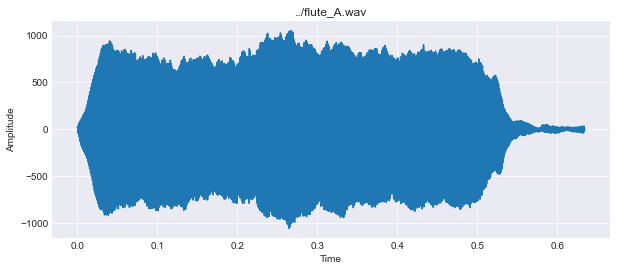

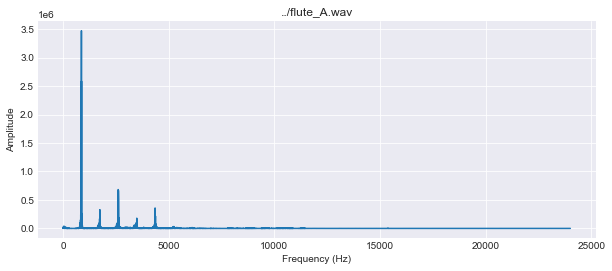

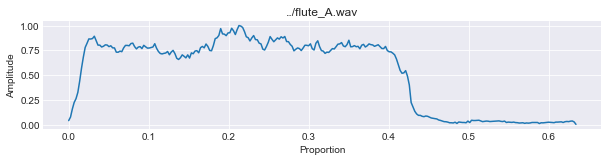

In [19]:
w = Wave(870)
w.extract('../flute_A.wav')
w.set_overtones(0)
w.set_enveloppe(0)

In [20]:
w.set_enveloppe = False

added overtones
Saving as name.wav


array([ 0.        , 39.2698762 , 74.39418918, ..., -4.51006189,
       -1.40627066,  1.59147209])

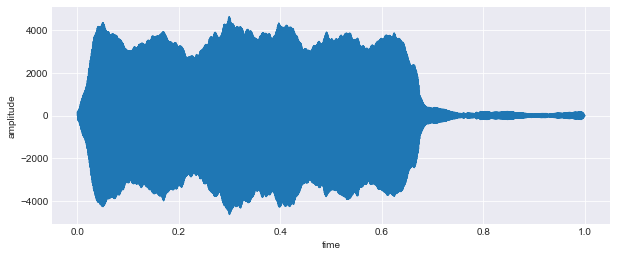

In [22]:
w.get_wave(1)

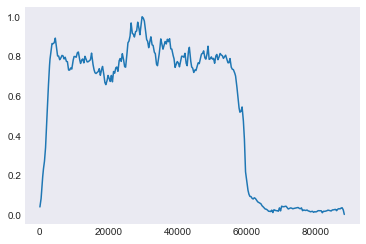

In [283]:
plt.plot(es)